# Wolock 2019, Mapping Distinct Bone Marrow Niche Populations and Their Differentiation Paths

[Scanpy Tutorial](https://scanpy-tutorials.readthedocs.io/en/latest/pbmc3k.html)
[Anndata documentation](https://anndata.readthedocs.io/en/stable/anndata.AnnData.html#anndata.AnnData)

wolock data need to trim off data first 18 col are metadata
`cut -d$'\t' GSE132151_bone_marrow_stroma.counts.tsv -f 1-18 > GSE132151_bone_marrow_stroma.metadata.tsv`
`cut -d$'\t' GSE132151_bone_marrow_stroma.counts.tsv -f 1,19- > GSE132151_bone_marrow_stroma.trimmed.tsv`


In [1]:
# import annotation
from scSecretome.annot import *
# import annotation
from scSecretome.sc import *
import pandas as pd
from os import *


scanpy==1.4.2 anndata==0.6.22.post1 umap==0.3.10 numpy==1.17.2 scipy==1.3.1 pandas==0.25.1 scikit-learn==0.21.3 statsmodels==0.10.1 python-igraph==0.7.1 louvain==0.6.1 


In [2]:
def filter_wolock(filename = '/home/hsher/wolock2019_stroma/GSE132151_bone_marrow_stroma.trimmed.tsv', 
                  metadata = '/home/hsher/wolock2019_stroma/GSE132151_bone_marrow_stroma.metadata.tsv', 
                 transcript_per_cell = 500, 
                 mito = 0.2):
    # read single cell expression matrix
    wo = read_raw_counts(filename, ignore_lines = 0, transpose = False)
    
    # join original publidation's metadata (cluster assigned)
    wo_metadata = pd.read_csv(metadata, header = 0, sep = '\t', index_col = 0)
    wo.obs = wo_metadata
    
    # filter cells with no enough transcript in cell
    sc.pp.filter_cells(wo, min_counts = transcript_per_cell)
    
    # benchmarking
    benchmarking(wo, species = 'mouse')
    
    # filter mitochondrial gene
    wo = wo[ wo.obs['percent_mito']<mito ]
    
    # normalize, by excluding frequent gene to avoid distorting data
    sc.pp.normalize_total(wo)
    
    # log1p should come before combating batch effect
    sc.pp.log1p(wo)
    
    return(wo)

In [3]:
wo = filter_wolock()

... reading from cache file cache/home-hsher-wolock2019_stroma-GSE132151_bone_marrow_stroma.trimmed.h5ad
filtered out 8416 cells that have less than 500 counts


Trying to set attribute `.obs` of view, making a copy.
... storing 'barcode' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'pass_filter' as categorical
Trying to set attribute `.obs` of view, making a copy.
... storing 'cluster' as categorical


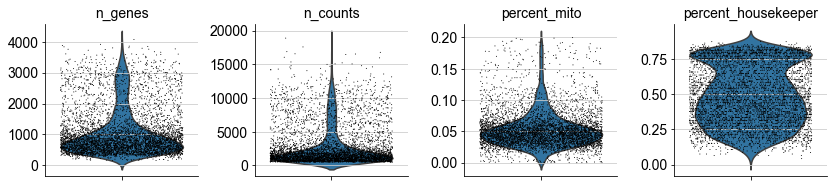

In [4]:
sc.pl.violin(wo, ['n_genes', 'n_counts', 'percent_mito', 'percent_housekeeper'],
             jitter=0.4, multi_panel=True)

In [5]:
def previsualize(concat, species = 'human'):
    '''
    This part should be modulized
    
    '''
    # calling various marker gene from literature
    lineage_calling(concat, species = species)
    
    # set the raw data to log form
    concat.raw = concat

    # set highly variable genes
    sc.pp.highly_variable_genes(concat, min_mean=0.0125, max_mean=3, min_disp=0.5)

    # see if batch effect correction changes the result
    # principle component analysis
    sc.tl.pca(concat, svd_solver='arpack')

    # compute neibors for PC
    sc.pp.neighbors(concat, n_neighbors=4, n_pcs=40) # wolock as slightly different params
    
    # compute umap
    sc.tl.umap(concat) 
    
    # compute louvain cluster
    sc.tl.louvain(concat)
    
    #performing Diffusion Pseudotime analysis: don't know how to set param
    sc.tl.dpt(concat, n_branchings=1)

    return(concat)
    

In [6]:
previsualize(wo, species = 'mouse')

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:01.44)
computing neighbors
    using 'X_pca' with n_pcs = 40
    finished (0:00:03.20) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP
    using 'X_pca' with n_pcs = 40


/home/hsher/miniconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 2 separate connected components using meta-embedding (experimental)
  n_components


    finished (0:00:08.62) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.21) --> found 22 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
    adata.uns['iroot'] = root_cell_index
    adata.var['xroot'] = adata[root_cell_name, :].X
computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [1.         1.         0.9996123  0.99952686 0.99910384 0.99867034
     0.9979834  0.99711245 0.9970065  0.9943876  0.99293417 0.9899742
     0.9895798  0.98748493 0.98568845]
    finished (0:00:00.40) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)
computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00.01) --> added

    'dpt_groups', the branching subgroups of dpt (adata.obs)
    'dpt_order', cell order (adata.obs)


AnnData object with n_obs × n_vars = 5024 × 25289 
    obs: 'barcode', 'library', 'sample', 'n_genes', 'n_counts', 'mito_frac', 'pass_filter', 'cluster', 'SPRING_x', 'SPRING_y', 'PBA_Potential', 'PBA_Pr_Adipo', 'PBA_Pr_Osteo', 'PBA_Pr_Chondro', 'PBA_Osteo_pseudotime', 'PBA_Chondro_pseudotime', 'PBA_Adipo_pseudotime', 'percent_mito', 'percent_housekeeper', 'B Cell Lineage', 'Basophil Lineage', 'Dendritic Cell Lineage', 'Eosinophil Lineage', 'Erythrocyte Lineage', 'Macrophage Lineage', 'Mast Cell Lineage', 'Megakaryocyte Lineage', 'Multi Potential Progenitor', 'NK Cell Lineage', 'Neutrophil Lineage', 'T Cell Lineage', 'C', 'O1', 'O2', 'O3', 'P1', 'P2', 'P3', 'P4', 'V1', 'V2', 'louvain', 'dpt_groups', 'dpt_order', 'dpt_order_indices'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'louvain', 'diffmap_evals', 'dpt_changepoints', 'dpt_grouptips'
    obsm: 'X_pca', 'X_umap', 'X_diffmap'
    varm: 'PCs'

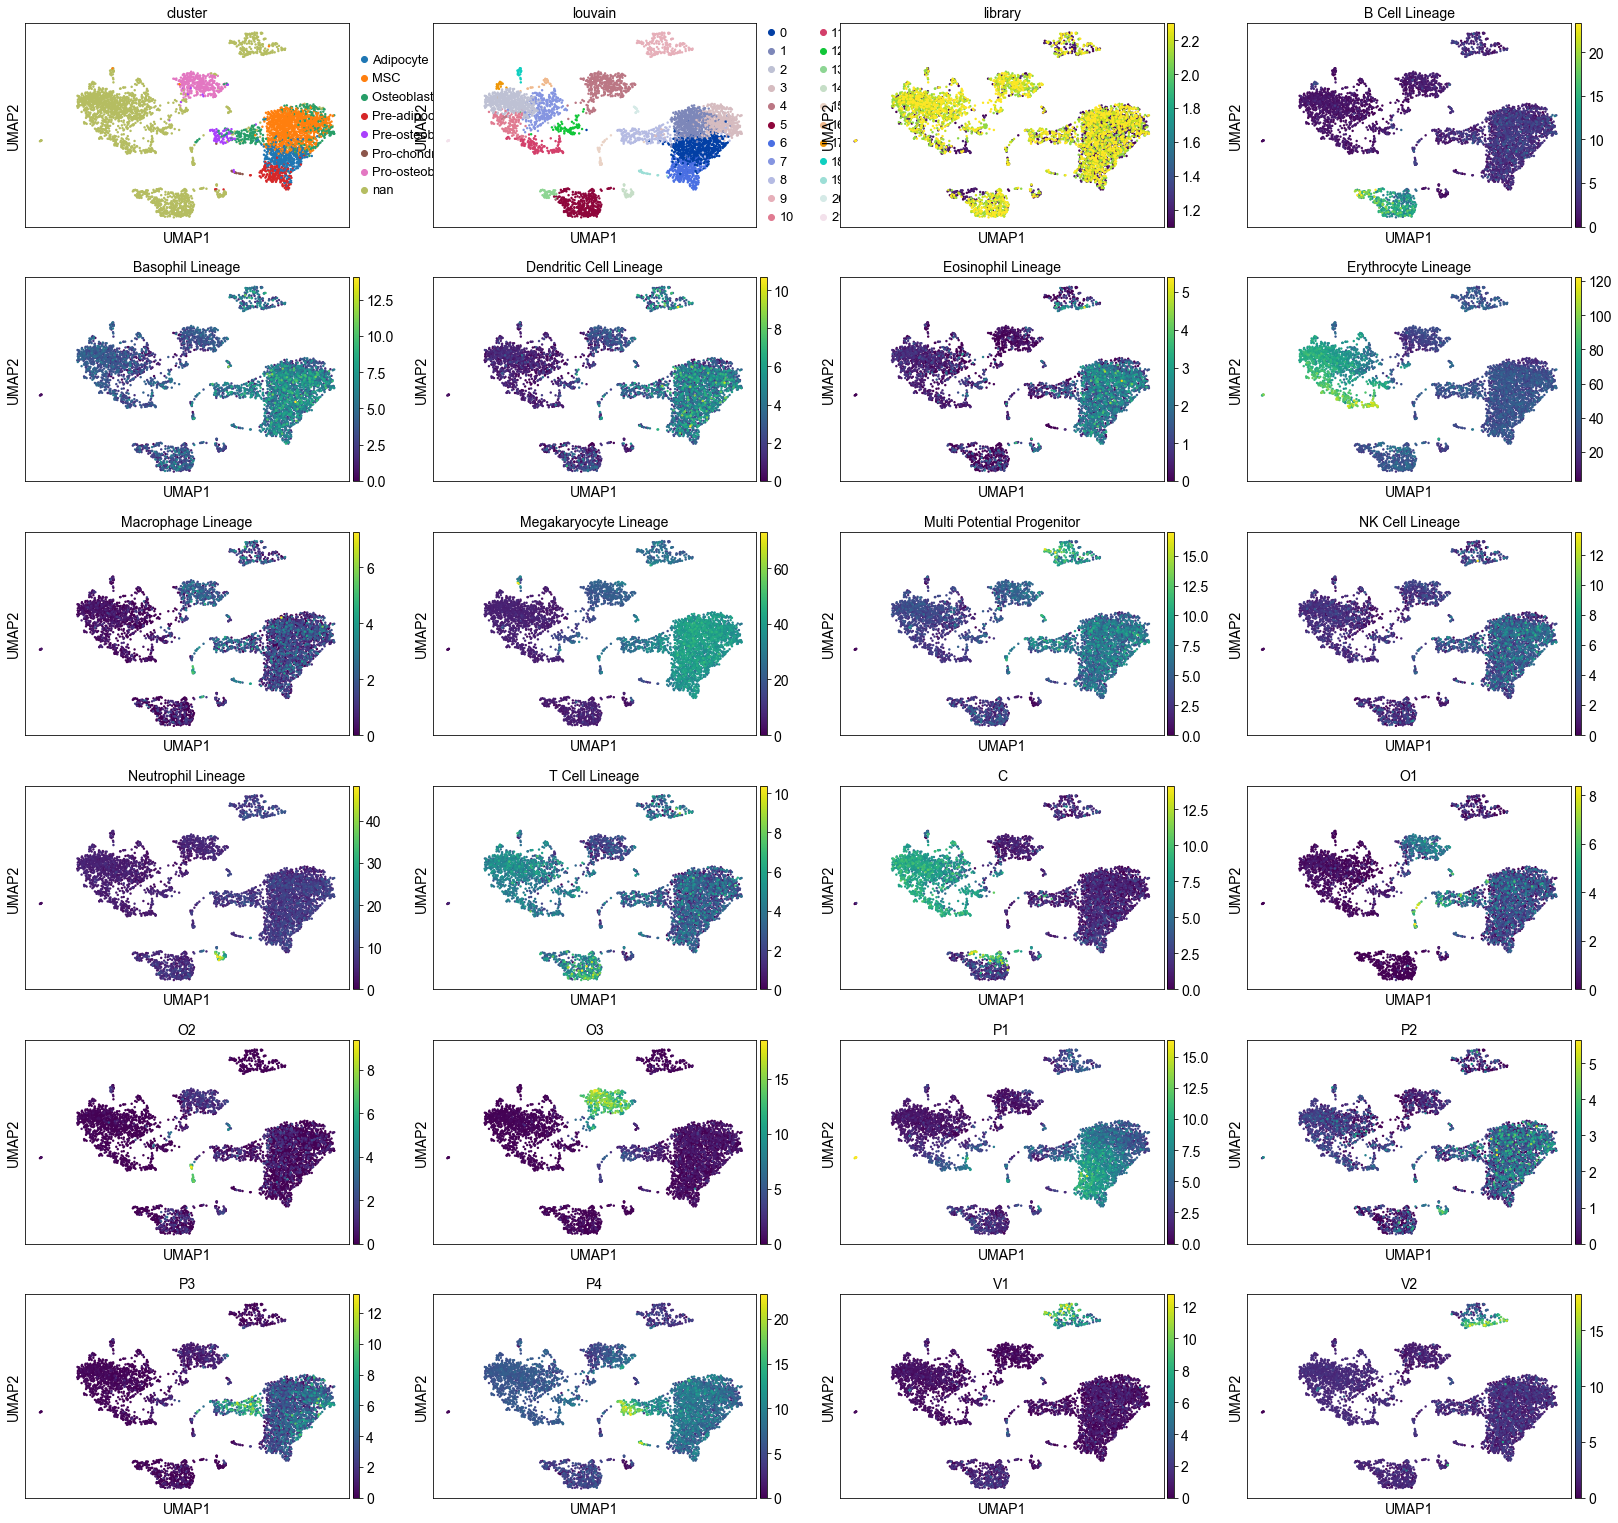

In [7]:
sc.pl.umap(wo, color=['cluster','louvain','library','B Cell Lineage', 'Basophil Lineage', 'Dendritic Cell Lineage',
       'Eosinophil Lineage', 'Erythrocyte Lineage', 'Macrophage Lineage',
       'Megakaryocyte Lineage', 'Multi Potential Progenitor',
       'NK Cell Lineage', 'Neutrophil Lineage', 'T Cell Lineage', 'C', 'O1', 'O2', 'O3', 'P1', 'P2', 'P3', 'P4',
       'V1', 'V2'], use_raw=False)

drawing single-cell graph using layout "fa"
    finished (0:00:40.46) --> added
    'X_draw_graph_fa', graph_drawing coordinates (adata.obsm)


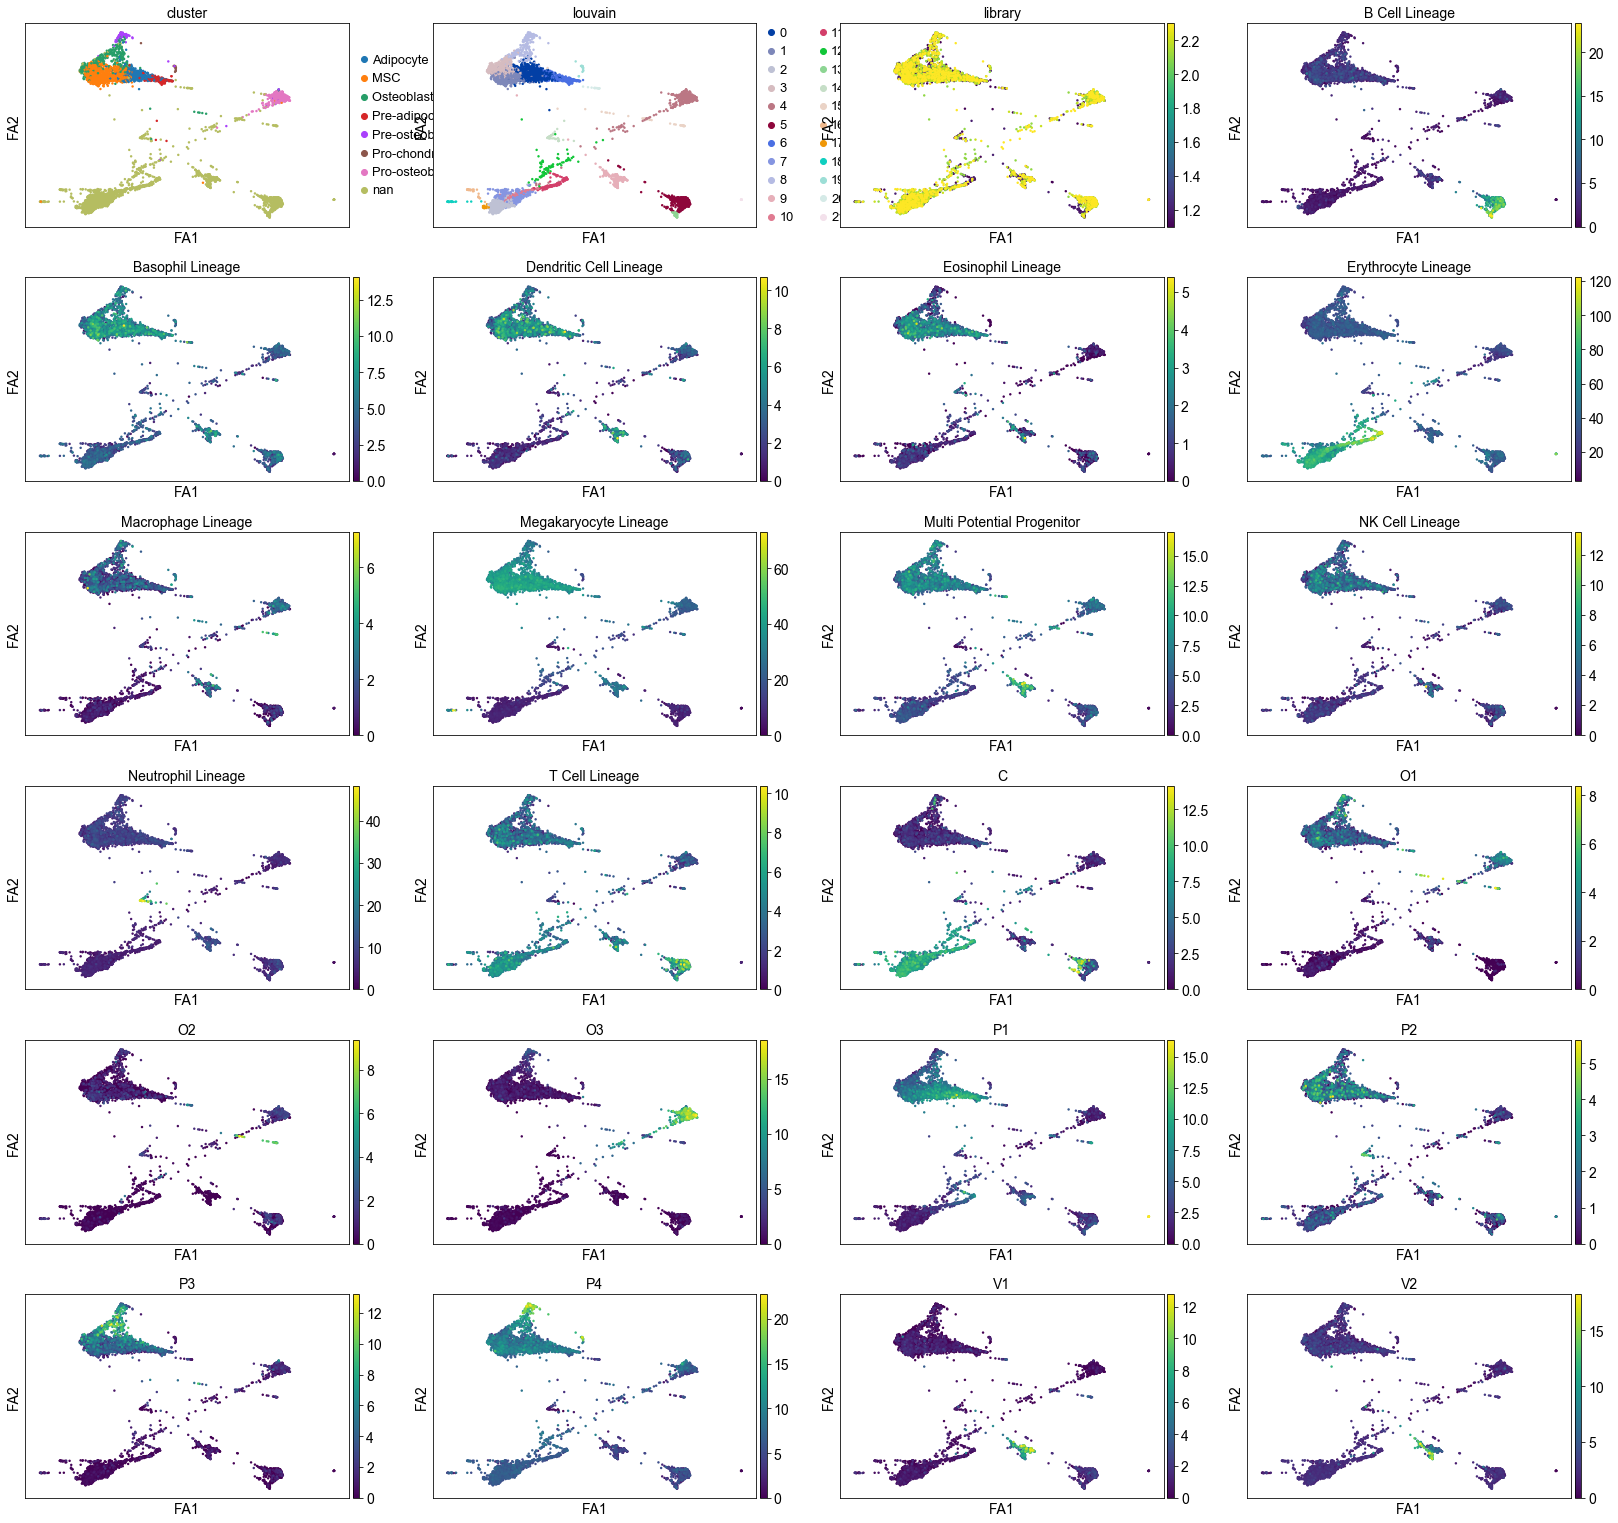

In [8]:
sc.tl.draw_graph(wo)
sc.pl.draw_graph(wo, color=['cluster','louvain','library','B Cell Lineage', 'Basophil Lineage', 'Dendritic Cell Lineage',
       'Eosinophil Lineage', 'Erythrocyte Lineage', 'Macrophage Lineage',
       'Megakaryocyte Lineage', 'Multi Potential Progenitor',
       'NK Cell Lineage', 'Neutrophil Lineage', 'T Cell Lineage', 'C', 'O1', 'O2', 'O3', 'P1', 'P2', 'P3', 'P4',
       'V1', 'V2'], use_raw=False)

In [9]:
wo.write('/home/hsher/processed_single_cell_data/wolock.h5ad')

# Single cell transcriptome profiling of the bone marrow niche at steady state and under stress conditions, nature 2019

In [10]:
def filter_tikhonova(filename,  
                 transcript_per_cell = 1000, 
                 mito = 0.1):
    # read single cell expression matrix
    base = '/home/hsher/nature2019_mice_niche/'
    wo = read_raw_counts(base+filename, ignore_lines = 0, transpose = True)
    
        
    # filter cells with no enough transcript in cell
    sc.pp.filter_cells(wo, min_counts = transcript_per_cell)
    
    # benchmarking
    benchmarking(wo, species = 'mouse')
    
    # filter mitochondrial gene
    wo = wo[ wo.obs['percent_mito']<mito ]
    
    # normalize, by excluding frequent gene to avoid distorting data
    sc.pp.normalize_total(wo)
    
    # log1p should come before combating batch effect
    sc.pp.log1p(wo)
    
    return(wo)

In [11]:
sample_three = listdir('/home/hsher/nature2019_mice_niche/') # mice stroma data nature 2019

In [12]:
sample_three.remove('GSE123078_RAW.tar')

In [13]:
sample_three

['GSM3494770_vecad-5fu.counts.raw.txt',
 'GSM3494771_vecad-ctrl.counts.raw.txt',
 'GSM3494768_lepr-5fu.counts.raw.txt',
 'GSM3494769_lepr-ctrl.counts.raw.txt']

Only considering the two last: ['.raw', '.txt'].
Only considering the two last: ['.raw', '.txt'].
... reading from cache file cache/home-hsher-nature2019_mice_niche-GSM3494770_vecad-5fu.counts.raw.h5ad
GSM3494770_vecad-5fu.counts.raw.txt


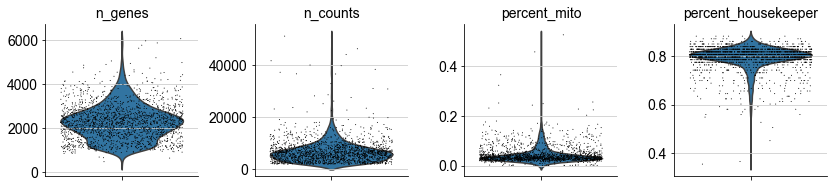

Only considering the two last: ['.raw', '.txt'].
Only considering the two last: ['.raw', '.txt'].
... reading from cache file cache/home-hsher-nature2019_mice_niche-GSM3494771_vecad-ctrl.counts.raw.h5ad
GSM3494771_vecad-ctrl.counts.raw.txt


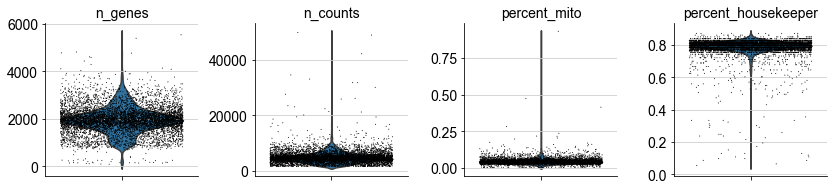

Only considering the two last: ['.raw', '.txt'].
Only considering the two last: ['.raw', '.txt'].
... reading from cache file cache/home-hsher-nature2019_mice_niche-GSM3494768_lepr-5fu.counts.raw.h5ad
GSM3494768_lepr-5fu.counts.raw.txt


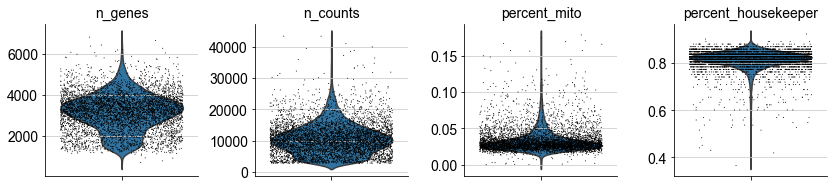

Only considering the two last: ['.raw', '.txt'].
Only considering the two last: ['.raw', '.txt'].
... reading from cache file cache/home-hsher-nature2019_mice_niche-GSM3494769_lepr-ctrl.counts.raw.h5ad
GSM3494769_lepr-ctrl.counts.raw.txt


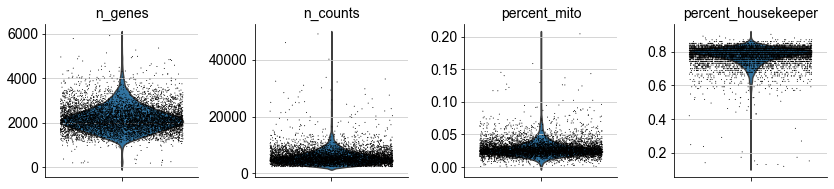

In [14]:
for s in sample_three:
    # run benchmarking
    d = read_raw_counts('/home/hsher/nature2019_mice_niche/'+s, ignore_lines = 0, transpose = True)
    benchmarking(d, species = 'mouse')
    
    # see benchmarking result
    print(s)
    sc.pl.violin(d, ['n_genes', 'n_counts', 'percent_mito', 'percent_housekeeper'], jitter=0.4, multi_panel=True)

In [15]:
lepr = filter_tikhonova('GSM3494769_lepr-ctrl.counts.raw.txt')
vecad = filter_tikhonova('GSM3494771_vecad-ctrl.counts.raw.txt')
lepr.obs['cluster']='lepr'
vecad.obs['cluster']='vecad'

Only considering the two last: ['.raw', '.txt'].
Only considering the two last: ['.raw', '.txt'].
... reading from cache file cache/home-hsher-nature2019_mice_niche-GSM3494769_lepr-ctrl.counts.raw.h5ad
Only considering the two last: ['.raw', '.txt'].
Only considering the two last: ['.raw', '.txt'].
... reading from cache file cache/home-hsher-nature2019_mice_niche-GSM3494771_vecad-ctrl.counts.raw.h5ad


Trying to set attribute `.obs` of view, making a copy.
Trying to set attribute `.obs` of view, making a copy.


In [16]:
# concat them
concat_three = lepr.concatenate(vecad)

In [17]:
previsualize(concat_three, species = 'mouse')

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:00.63)
computing neighbors
    using 'X_pca' with n_pcs = 40


/home/hsher/miniconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../miniconda3/lib/python3.7/site-packages/umap/rp_tree.py", line 135:
@numba.njit(fastmath=True, nogil=True, parallel=True)
def euclidean_random_projection_split(data, indices, rng_state):
^

  self.func_ir.loc))
/home/hsher/miniconda3/lib/python3.7/site-packages/umap/nndescent.py:92: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../miniconda3/lib/python3.7/site-packages/umap/utils.py", line 409:
@num

    finished (0:00:06.62) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP
    using 'X_pca' with n_pcs = 40


/home/hsher/miniconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 6 separate connected components using meta-embedding (experimental)
  n_components


    finished (0:00:07.57) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.65) --> found 26 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
    adata.uns['iroot'] = root_cell_index
    adata.var['xroot'] = adata[root_cell_name, :].X
computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [1.         1.         1.         1.         0.9999483  0.9993392
     0.9984352  0.99820316 0.9975693  0.99688995 0.9956324  0.994982
     0.992606   0.9924817  0.99207044]
    finished (0:00:01.01) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)
computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00.02) --> added

    'dpt_groups', the branching subgroups of dpt (adata.obs)
    'dpt_order', cell order (adata.obs)


AnnData object with n_obs × n_vars = 12951 × 13910 
    obs: 'batch', 'cluster', 'n_counts', 'n_genes', 'percent_housekeeper', 'percent_mito', 'B Cell Lineage', 'Basophil Lineage', 'Dendritic Cell Lineage', 'Eosinophil Lineage', 'Erythrocyte Lineage', 'Macrophage Lineage', 'Mast Cell Lineage', 'Megakaryocyte Lineage', 'Multi Potential Progenitor', 'NK Cell Lineage', 'Neutrophil Lineage', 'T Cell Lineage', 'C', 'O1', 'O2', 'O3', 'P1', 'P2', 'P3', 'P4', 'V1', 'V2', 'louvain', 'dpt_groups', 'dpt_order', 'dpt_order_indices'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'louvain', 'diffmap_evals', 'dpt_changepoints', 'dpt_grouptips'
    obsm: 'X_pca', 'X_umap', 'X_diffmap'
    varm: 'PCs'

... storing 'cluster' as categorical


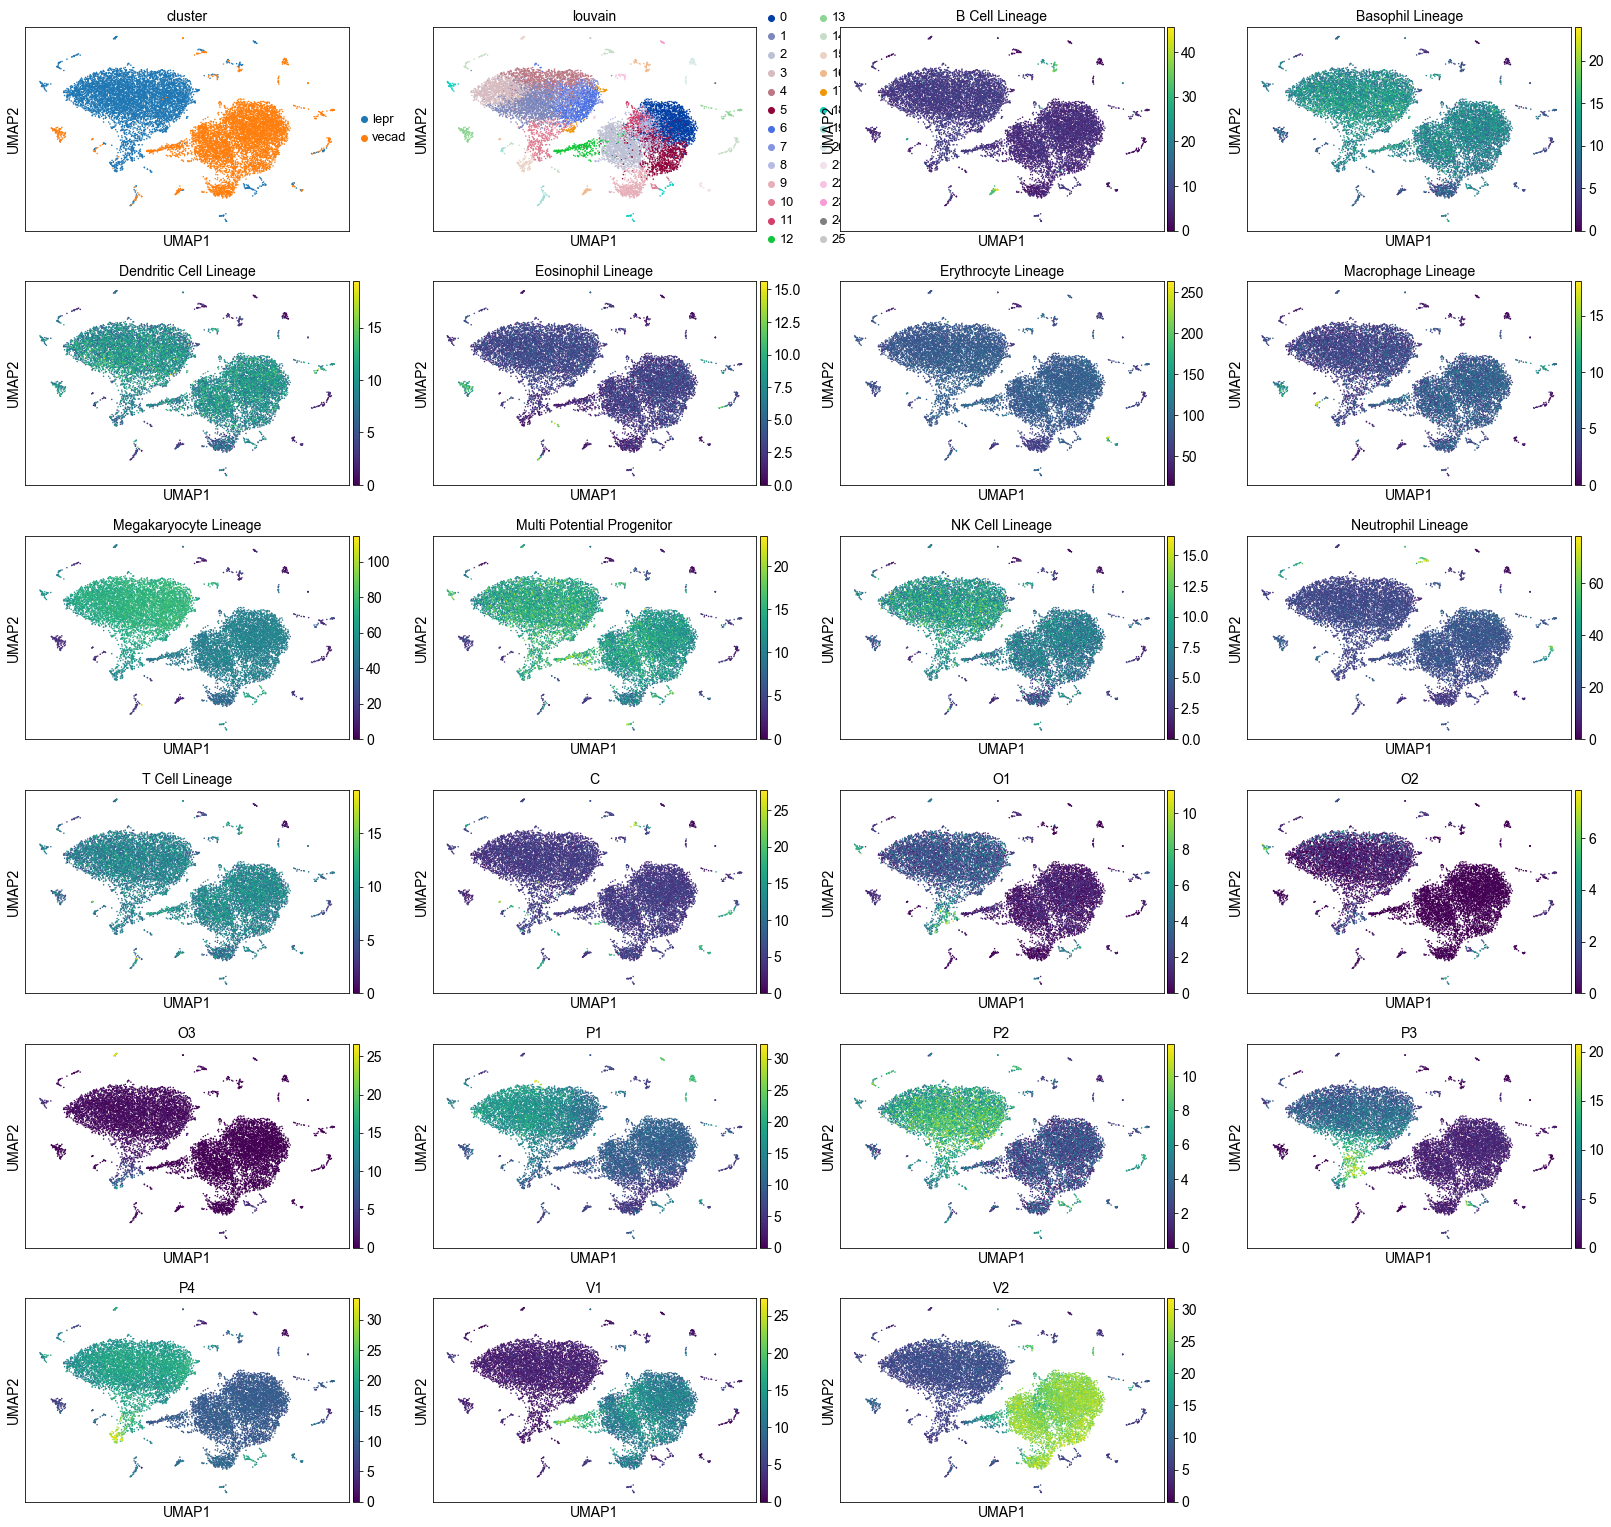

In [18]:
sc.pl.umap(concat_three, color=['cluster','louvain','B Cell Lineage', 'Basophil Lineage', 'Dendritic Cell Lineage',
       'Eosinophil Lineage', 'Erythrocyte Lineage', 'Macrophage Lineage',
       'Megakaryocyte Lineage', 'Multi Potential Progenitor',
       'NK Cell Lineage', 'Neutrophil Lineage', 'T Cell Lineage', 'C', 'O1', 'O2', 'O3', 'P1', 'P2', 'P3', 'P4',
       'V1', 'V2'], use_raw=False)

In [19]:
concat_three.write('/home/hsher/processed_single_cell_data/tikhonova.h5ad')

# Try to integrate data from different source

## see overlapping genes are very different

In [20]:
print('overlapping genes', len(set(wo.var.index).intersection(set(lepr.var.index)))) # no overlap[!?]

overlapping genes 14585


In [21]:
discrepency_wo = set(wo.var.index)-(set(lepr.var.index))
discrepency_lepr = set(lepr.var.index)-(set(wo.var.index))

In [22]:
print(len(discrepency_lepr), len(discrepency_wo))

778 10704


In [23]:
# if convert them to ensembl ID what will happed?
import mygene

mg = mygene.MyGeneInfo()
d_wol = mg.querymany(discrepency_wo, scopes='symbol', fields='all', species=10090, as_dataframe = True) # scopes not equal to mgi
d_lepr = mg.querymany(discrepency_lepr, scopes='symbol', fields='all', species=10090, as_dataframe = True)

querying 1-1000...done.
querying 1001-2000...done.
querying 2001-3000...done.
querying 3001-4000...done.
querying 4001-5000...done.
querying 5001-6000...done.
querying 6001-7000...done.
querying 7001-8000...done.
querying 8001-9000...done.
querying 9001-10000...done.
querying 10001-10704...done.
Finished.
3239 input query terms found dup hits:
	[('A630031M04Rik', 2), ('Trav9n-2', 2), ('Gm8888', 2), ('1700025F24Rik', 2), ('Gm15478', 2), ('Gm106
490 input query terms found no hit:
	['Gm42416', 'Gm13177', 'AC165294.2', 'Gm933', '4921530L21Rik', 'Gm4763', 'Pet2', 'Gm43194', '4932411
Pass "returnall=True" to return complete lists of duplicate or missing query terms.
querying 1-778...done.
Finished.
177 input query terms found dup hits:
	[('Gm7676', 2), ('A530017D24Rik', 2), ('2010320M18Rik', 3), ('AY036118', 2), ('9130604C24Rik', 2), (
180 input query terms found no hit:
	['Gm26776', 'Gm16701.1', 'Itgam.1', 'Gm43949', 'Gm13251', 'Gm26508', 'Gm42950', 'Gm26734', 'Gm26883'
Pass "returnall=Tru

In [24]:
set(d_wol['ensembl.gene']).intersection(set(d_lepr['ensembl.gene'])) # no overlap, it's not a naming issue

{nan}

In [25]:
d_wol['name'].str.contains('predicted').sum() # a lot of predicted genes but now we sequenced them they are not PREDICTED

3596

In [26]:
d_lepr['name'].str.contains('predicted').sum() # a lot of predicted genes but now we sequenced them they are not PREDICTED

351

In [27]:
# what are the rest
d_wol.loc[~d_wol['name'].str.contains('predicted', na = False), 'name'] # a lot of predicted genes but now we sequenced them they are not PREDICTED

query
Gbp10                                 guanylate-binding protein 10
Rhox3e                                    reproductive homeobox 3E
Kir3dl1          killer cell immunoglobulin-like receptor, thre...
4833407H14Rik                           RIKEN cDNA 4833407H14 gene
Adra1a                               adrenergic receptor, alpha 1a
                                       ...                        
1500012K07Rik                           RIKEN cDNA 1500012K07 gene
1500012K07Rik                           RIKEN cDNA 1500012K07 gene
Igkj3                               immunoglobulin kappa joining 3
Igkj3                               immunoglobulin kappa joining 3
Krt7                                                     keratin 7
Name: name, Length: 10390, dtype: object

In [28]:
# what are the rest
d_lepr.loc[~d_lepr['name'].str.contains('predicted', na = False), 'name'] # a lot of predicted genes but now we sequenced them they are not PREDICTED

query
Gm7676           interferon induced transmembrane protein 1 pse...
Gm26776                                                        NaN
Zscan18                  zinc finger and SCAN domain containing 18
PISD                              phosphatidylserine decarboxylase
Gm16701.1                                                      NaN
                                       ...                        
Gm13157                                                        NaN
9930004E17Rik                           RIKEN cDNA 9930004E17 gene
9930004E17Rik                           RIKEN cDNA 9930004E17 gene
9930004E17Rik                           RIKEN cDNA 9930004E17 gene
Cpeb2            cytoplasmic polyadenylation element binding pr...
Name: name, Length: 609, dtype: object

## analysing combined set

In [29]:
combined_set = wo.concatenate(concat_three, join = 'inner', batch_key='batch')

In [30]:
previsualize(combined_set, species = 'mouse')

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:01.69)
computing neighbors
    using 'X_pca' with n_pcs = 40


/home/hsher/miniconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../miniconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


    finished (0:00:02.83) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP
    using 'X_pca' with n_pcs = 40


/home/hsher/miniconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 8 separate connected components using meta-embedding (experimental)
  n_components


    finished (0:00:11.08) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:00.76) --> found 32 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
    adata.uns['iroot'] = root_cell_index
    adata.var['xroot'] = adata[root_cell_name, :].X
computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [1.         1.         1.         1.         1.         1.
     0.99998575 0.9999021  0.9996868  0.9994315  0.99929607 0.9986738
     0.9985402  0.9984801  0.99708086]
    finished (0:00:03.26) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)
computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00.03) --> added

    'dpt_groups', the branching subgroups of dpt (adata.obs)
    'dpt_order', cell order (adata.obs)


AnnData object with n_obs × n_vars = 17975 × 13301 
    obs: 'B Cell Lineage', 'Basophil Lineage', 'C', 'Dendritic Cell Lineage', 'Eosinophil Lineage', 'Erythrocyte Lineage', 'Macrophage Lineage', 'Mast Cell Lineage', 'Megakaryocyte Lineage', 'Multi Potential Progenitor', 'NK Cell Lineage', 'Neutrophil Lineage', 'O1', 'O2', 'O3', 'P1', 'P2', 'P3', 'P4', 'PBA_Adipo_pseudotime', 'PBA_Chondro_pseudotime', 'PBA_Osteo_pseudotime', 'PBA_Potential', 'PBA_Pr_Adipo', 'PBA_Pr_Chondro', 'PBA_Pr_Osteo', 'SPRING_x', 'SPRING_y', 'T Cell Lineage', 'V1', 'V2', 'barcode', 'batch', 'cluster', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'library', 'louvain', 'mito_frac', 'n_counts', 'n_genes', 'pass_filter', 'percent_housekeeper', 'percent_mito', 'sample'
    var: 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'louvai

... storing 'barcode' as categorical
... storing 'cluster' as categorical
... storing 'pass_filter' as categorical
/home/hsher/miniconda3/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


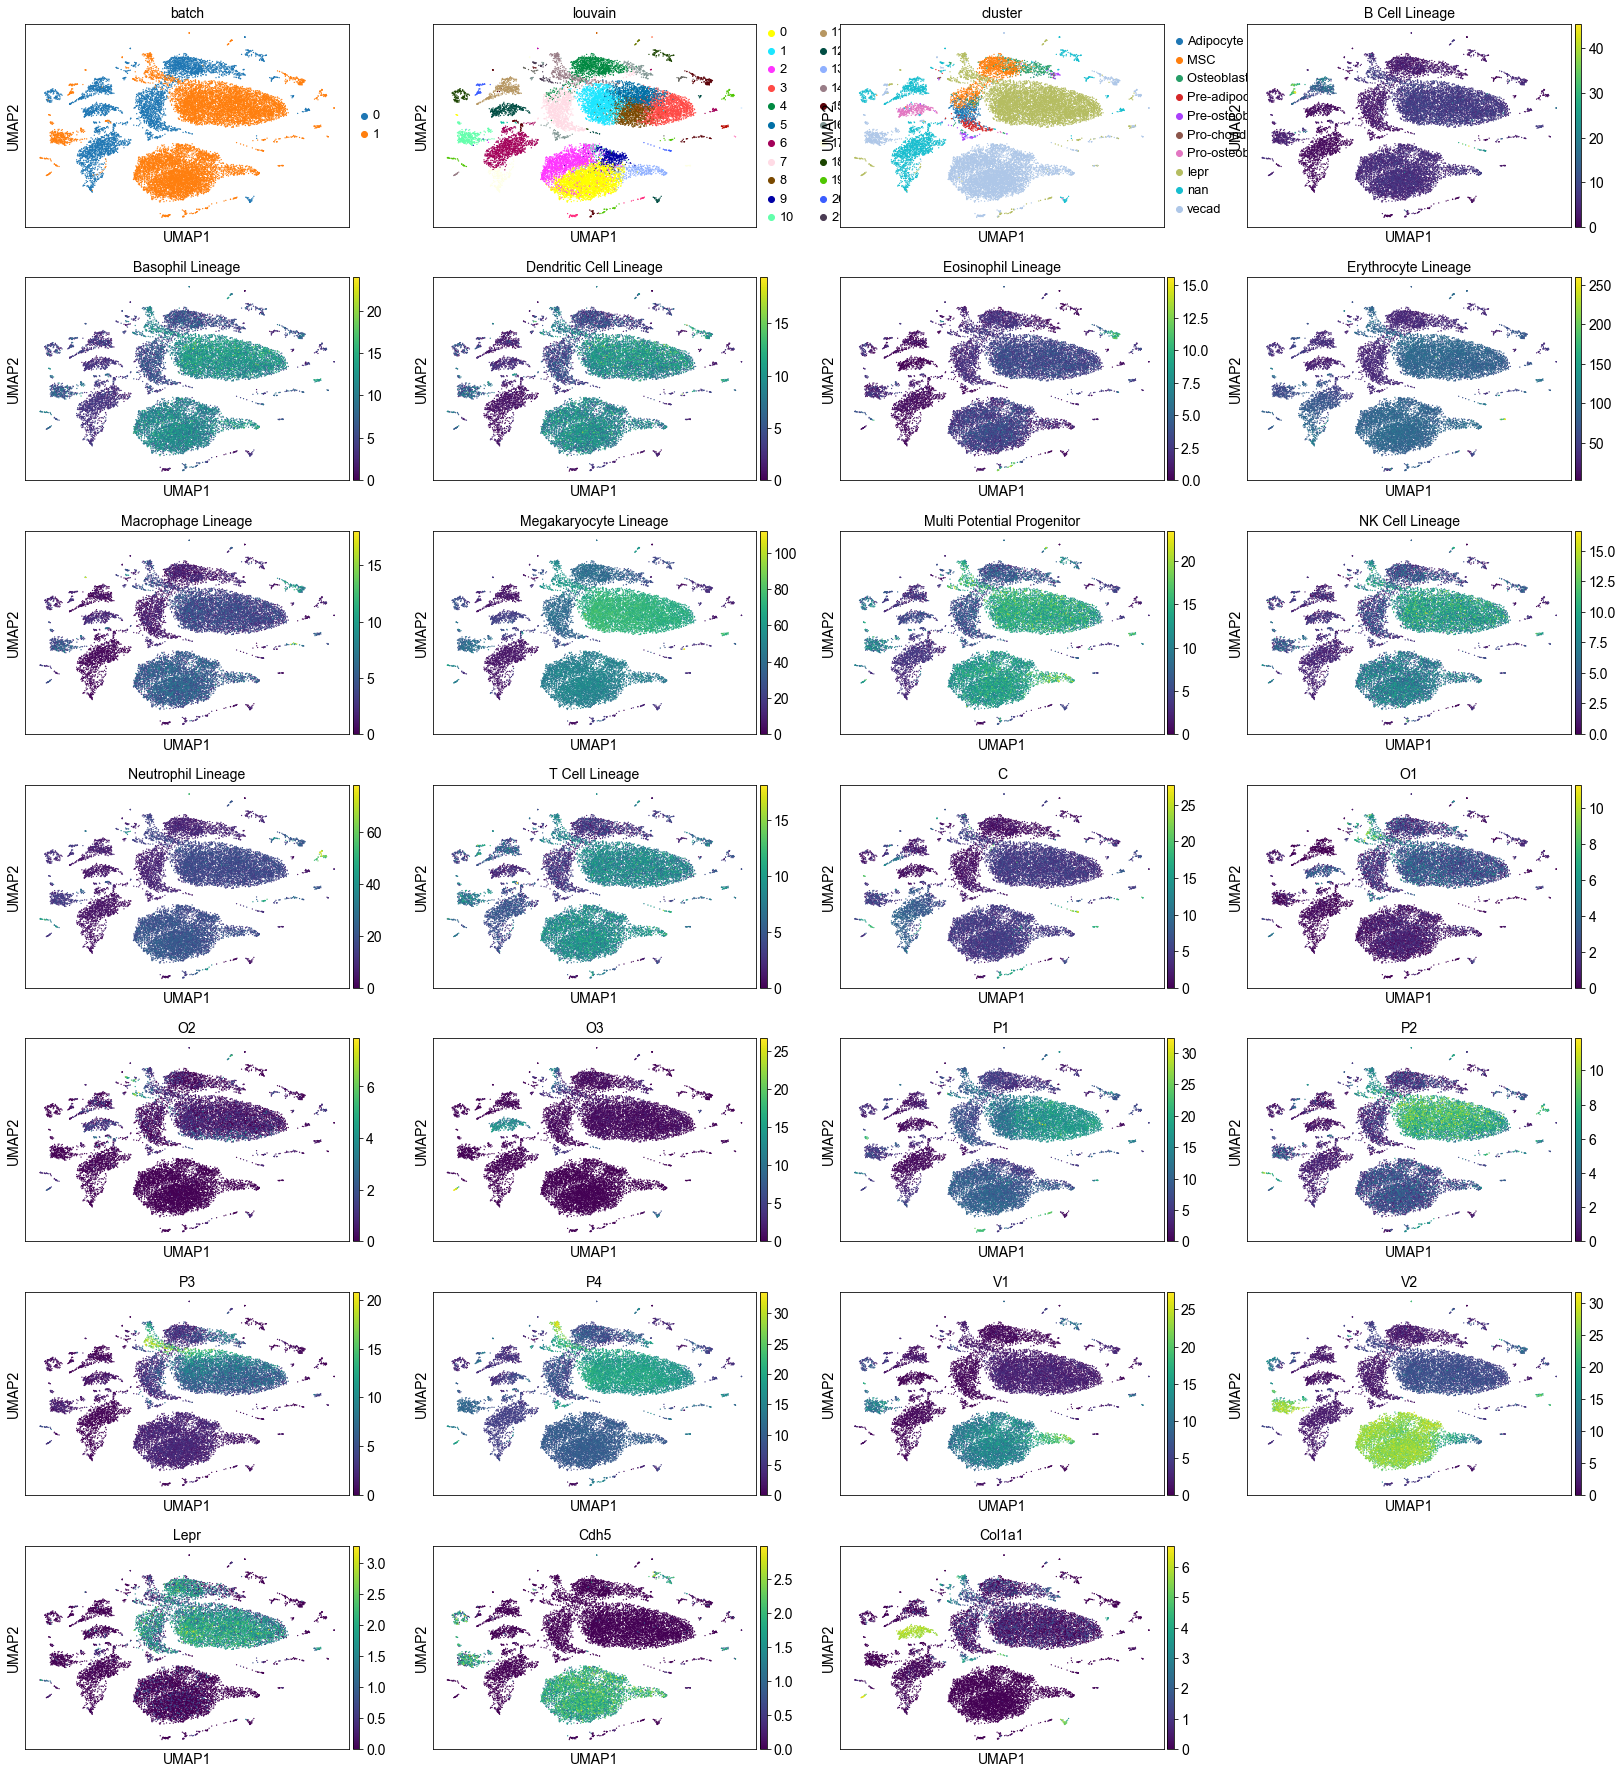

In [31]:
sc.pl.umap(combined_set, color=['batch','louvain','cluster','B Cell Lineage', 'Basophil Lineage', 'Dendritic Cell Lineage',
       'Eosinophil Lineage', 'Erythrocyte Lineage', 'Macrophage Lineage',
       'Megakaryocyte Lineage', 'Multi Potential Progenitor',
       'NK Cell Lineage', 'Neutrophil Lineage', 'T Cell Lineage', 'C', 'O1', 'O2', 'O3', 'P1', 'P2', 'P3', 'P4',
       'V1', 'V2', 'Lepr', 'Cdh5', 'Col1a1'], use_raw=False)

In [32]:
# try adjusting batch effect
combined_set = wo.concatenate(concat_three, join = 'inner', batch_key='batch')
sc.pp.combat(combined_set, key = 'batch')

... storing 'barcode' as categorical
... storing 'cluster' as categorical
... storing 'louvain' as categorical
... storing 'pass_filter' as categorical


Standardizing Data across genes.

Found 2 batches

Found 0 numerical variables:
	

Fitting L/S model and finding priors

Finding parametric adjustments



/home/hsher/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py:269: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "_it_sol" failed type inference due to: Cannot unify array(float64, 2d, C) and array(float64, 1d, C) for 'sum2', defined at /home/hsher/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py (311)

File "../miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py", line 311:
def _it_sol(s_data, g_hat, d_hat, g_bar, t2, a, b, conv=0.0001) -> Tuple[float, float]:
    <source elided>
        g_new = (t2*n*g_hat + d_old*g_bar) / (t2*n + d_old)
        sum2 = s_data - g_new.reshape((g_new.shape[0], 1)) @ np.ones((1, s_data.shape[1]))
        ^

[1] During: typing of assignment at /home/hsher/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py (313)

File "../miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_combat.py", line 313:
def _it_sol(s_data

Adjusting data



In [33]:
previsualize(combined_set, species = 'mouse')

--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)
computing PCA with n_comps = 50
computing PCA on highly variable genes
    finished (0:00:03.89)
computing neighbors
    using 'X_pca' with n_pcs = 40


/home/hsher/miniconda3/lib/python3.7/site-packages/numba/compiler.py:602: NumbaPerformanceWarning: 
The keyword argument 'parallel=True' was specified but no transformation for parallel execution was possible.

To find out why, try turning on parallel diagnostics, see http://numba.pydata.org/numba-doc/latest/user/parallel.html#diagnostics for help.

File "../miniconda3/lib/python3.7/site-packages/umap/nndescent.py", line 47:
    @numba.njit(parallel=True)
    def nn_descent(
    ^

  self.func_ir.loc))


    finished (0:00:02.62) --> added to `.uns['neighbors']`
    'distances', distances for each pair of neighbors
    'connectivities', weighted adjacency matrix
computing UMAP
    using 'X_pca' with n_pcs = 40


/home/hsher/miniconda3/lib/python3.7/site-packages/umap/spectral.py:229: UserWarning: Embedding a total of 5 separate connected components using meta-embedding (experimental)
  n_components


    finished (0:00:09.99) --> added
    'X_umap', UMAP coordinates (adata.obsm)
running Louvain clustering
    using the "louvain" package of Traag (2017)
    finished (0:00:01.04) --> found 30 clusters and added
    'louvain', the cluster labels (adata.obs, categorical)
    adata.uns['iroot'] = root_cell_index
    adata.var['xroot'] = adata[root_cell_name, :].X
computing Diffusion Maps using n_comps=15(=n_dcs)
    eigenvalues of transition matrix
    [1.         1.         1.         0.99997723 0.9998363  0.9995767
     0.99864346 0.9983678  0.9980922  0.9976816  0.9975111  0.9967892
     0.99649495 0.9951624  0.99498767]
    finished (0:00:01.21) --> added
    'X_diffmap', diffmap coordinates (adata.obsm)
    'diffmap_evals', eigenvalues of transition matrix (adata.uns)
computing Diffusion Pseudotime using n_dcs=10
    finished (0:00:00.04) --> added

    'dpt_groups', the branching subgroups of dpt (adata.obs)
    'dpt_order', cell order (adata.obs)


AnnData object with n_obs × n_vars = 17975 × 13301 
    obs: 'B Cell Lineage', 'Basophil Lineage', 'C', 'Dendritic Cell Lineage', 'Eosinophil Lineage', 'Erythrocyte Lineage', 'Macrophage Lineage', 'Mast Cell Lineage', 'Megakaryocyte Lineage', 'Multi Potential Progenitor', 'NK Cell Lineage', 'Neutrophil Lineage', 'O1', 'O2', 'O3', 'P1', 'P2', 'P3', 'P4', 'PBA_Adipo_pseudotime', 'PBA_Chondro_pseudotime', 'PBA_Osteo_pseudotime', 'PBA_Potential', 'PBA_Pr_Adipo', 'PBA_Pr_Chondro', 'PBA_Pr_Osteo', 'SPRING_x', 'SPRING_y', 'T Cell Lineage', 'V1', 'V2', 'barcode', 'batch', 'cluster', 'dpt_groups', 'dpt_order', 'dpt_order_indices', 'library', 'louvain', 'mito_frac', 'n_counts', 'n_genes', 'pass_filter', 'percent_housekeeper', 'percent_mito', 'sample'
    var: 'highly_variable-0', 'means-0', 'dispersions-0', 'dispersions_norm-0', 'highly_variable-1', 'means-1', 'dispersions-1', 'dispersions_norm-1', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'pca', 'neighbors', 'louvai

/home/hsher/miniconda3/lib/python3.7/site-packages/anndata/core/anndata.py:846: FutureWarning: In anndata v0.7+, arrays contained within an AnnData object will maintain their dimensionality. For example, prior to v0.7 `adata[0, 0].X` returned a scalar and `adata[0, :]` returned a 1d array, post v0.7 they will return two dimensional arrays. If you would like to get a one dimensional array from your AnnData object, consider using the `adata.obs_vector`, `adata.var_vector` methods or accessing the array directly.
  warn_flatten()


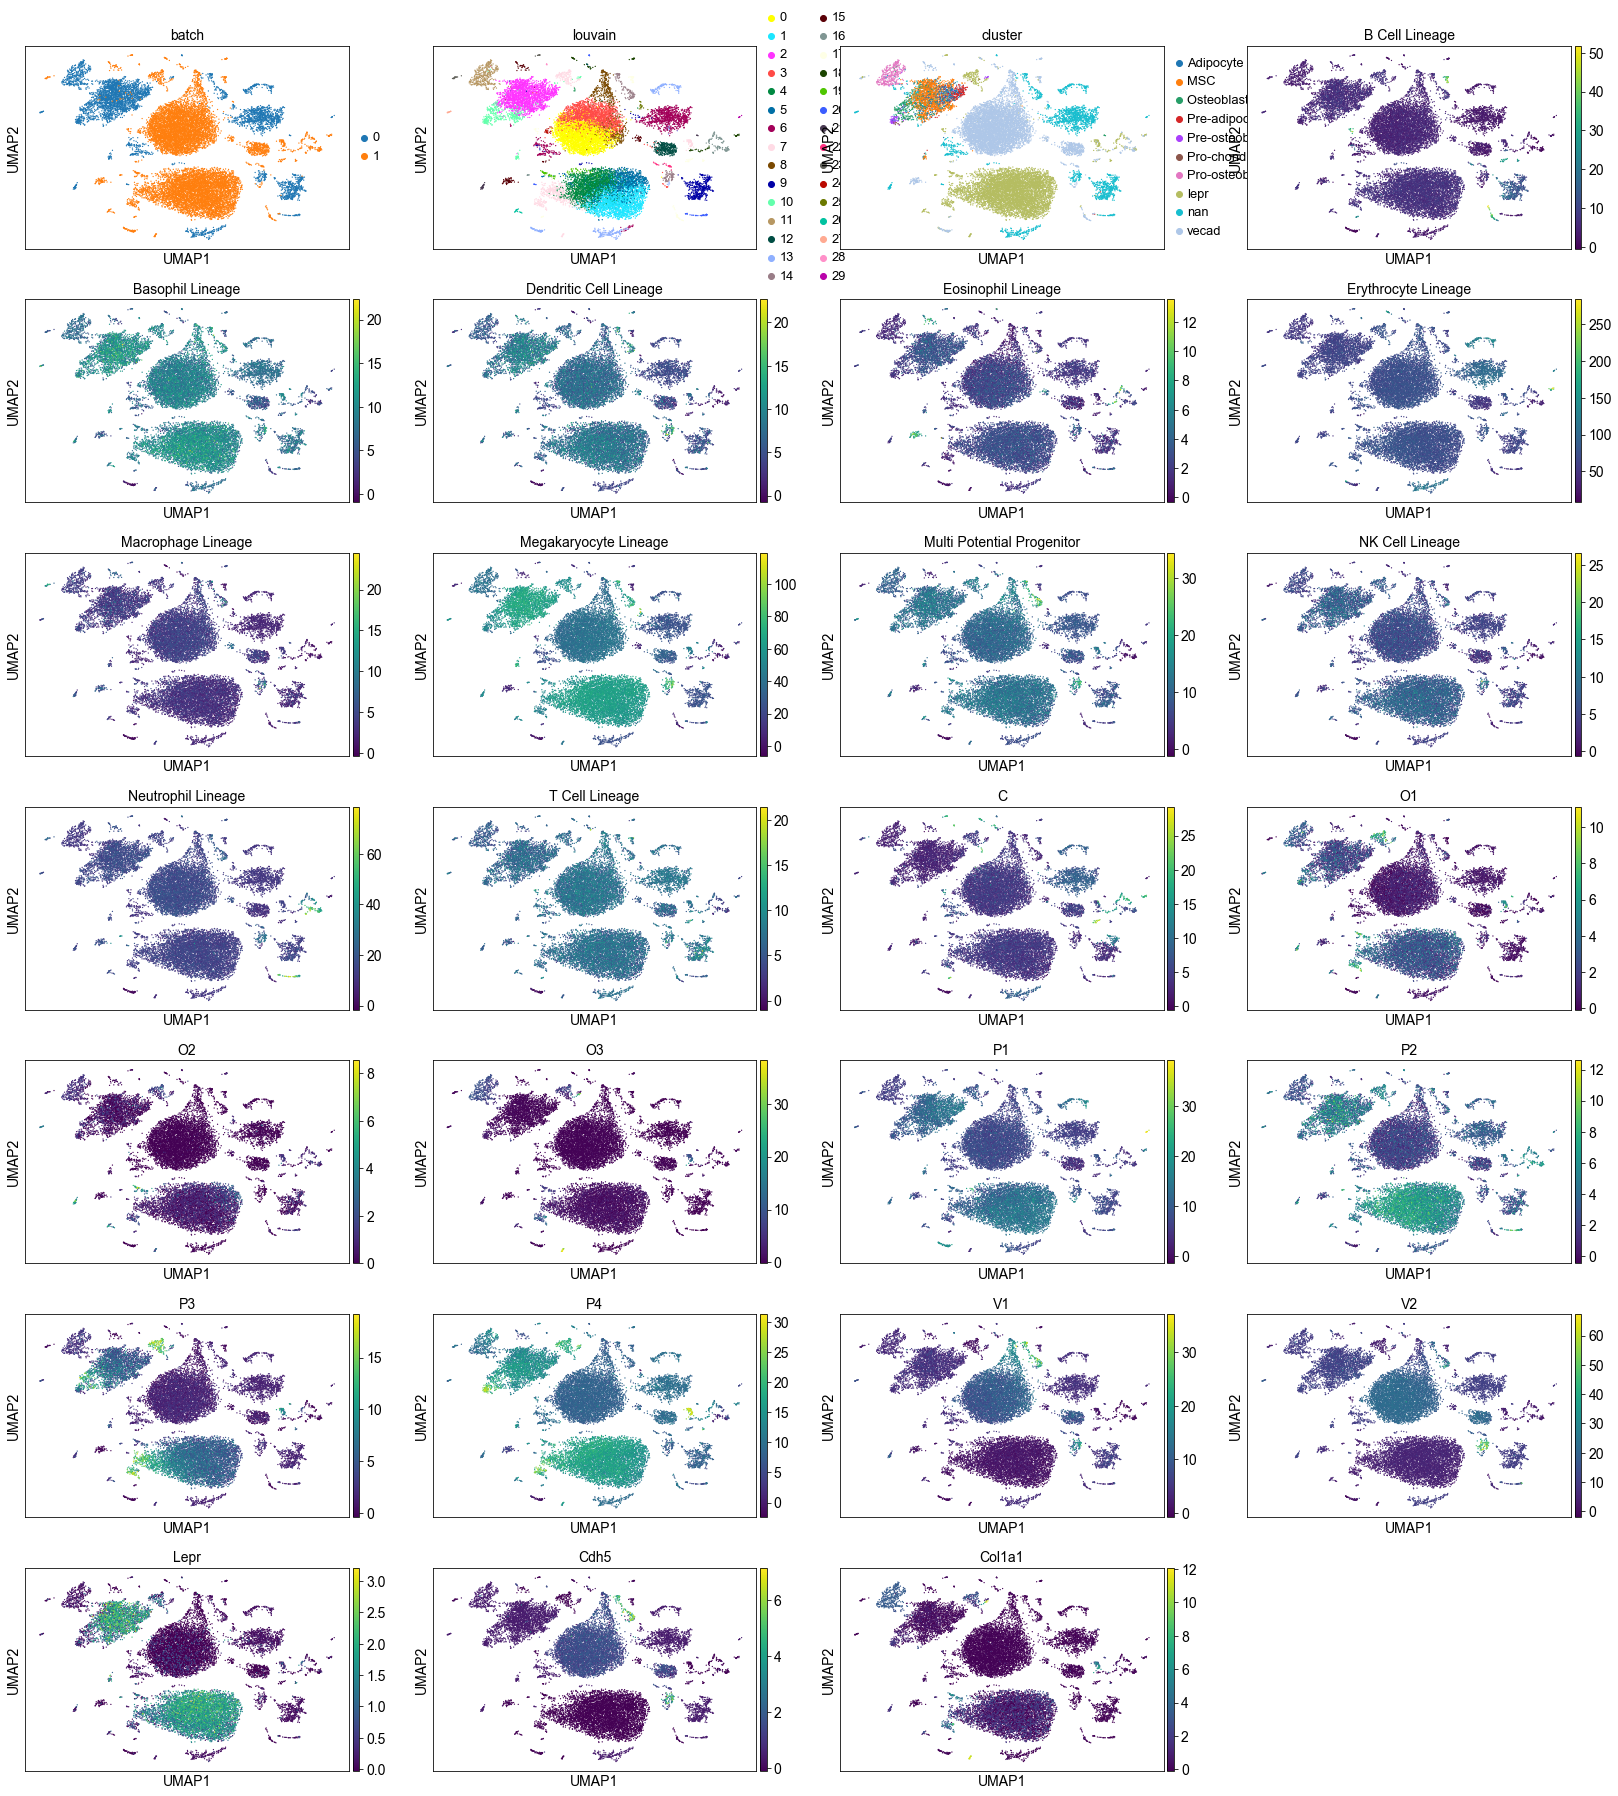

In [34]:
sc.pl.umap(combined_set, color=['batch','louvain','cluster','B Cell Lineage', 'Basophil Lineage', 'Dendritic Cell Lineage',
       'Eosinophil Lineage', 'Erythrocyte Lineage', 'Macrophage Lineage',
       'Megakaryocyte Lineage', 'Multi Potential Progenitor',
       'NK Cell Lineage', 'Neutrophil Lineage', 'T Cell Lineage', 'C', 'O1', 'O2', 'O3', 'P1', 'P2', 'P3', 'P4',
       'V1', 'V2', 'Lepr', 'Cdh5', 'Col1a1'], use_raw=False)
# combat does not help correct batch effect. instead it messed up data

In [35]:
combined_set.write('/home/hsher/processed_single_cell_data/combined_stroma.h5ad')